<a href="https://colab.research.google.com/github/InbalBolshinsky/DL_finalProject/blob/main/Lung_Cancer_Project_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
%config Completer.use_jedi = False
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import seaborn as sns
import cv2
import random
import os
import imageio
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
from collections import Counter

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import accuracy_score, recall_score, precision_score, classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, RepeatedStratifiedKFold
from imblearn.over_sampling import SMOTE

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from keras.applications import resnet
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3, EfficientNetB4, EfficientNetB5, EfficientNetB6, EfficientNetB7
from keras.applications.resnet import ResNet50

In [7]:
!pip install kagglehub
import kagglehub

# Download dataset (default behavior)
path = kagglehub.dataset_download("adityamahimkar/iqothnccd-lung-cancer-dataset")

print("Dataset downloaded to:", path)



Dataset downloaded to: /root/.cache/kagglehub/datasets/adityamahimkar/iqothnccd-lung-cancer-dataset/versions/2


In [8]:
from google.colab import drive
drive.mount('/content/drive')

# Copy dataset from default location to Google Drive
!cp -r /root/.cache/kagglehub/datasets/adityamahimkar/iqothnccd-lung-cancer-dataset /content/drive/MyDrive/KaggleDatasets/LungCancer


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
cp: cannot create directory '/content/drive/MyDrive/KaggleDatasets/LungCancer': No such file or directory


In [9]:
import os

base_path = "/root/.cache/kagglehub/datasets/adityamahimkar/iqothnccd-lung-cancer-dataset/versions/2"
print("Base path:", base_path)

if os.path.exists(base_path):
    for root, dirs, files in os.walk(base_path):
        print(f"Directory: {root}")
        for d in dirs:
            print(f"  Subdirectory: {d}")
        for f in files:
            print(f"  File: {f}")
else:
    print(f"Path does not exist: {base_path}")



Base path: /root/.cache/kagglehub/datasets/adityamahimkar/iqothnccd-lung-cancer-dataset/versions/2
Directory: /root/.cache/kagglehub/datasets/adityamahimkar/iqothnccd-lung-cancer-dataset/versions/2
  Subdirectory: Test cases
  Subdirectory: The IQ-OTHNCCD lung cancer dataset
Directory: /root/.cache/kagglehub/datasets/adityamahimkar/iqothnccd-lung-cancer-dataset/versions/2/Test cases
  File: 000223_09_02_146.png
  File: 000058_08_01_035.png
  File: 000019_01_01_021.png
  File: 000063_01_01_155.png
  File: 000103_02_01_060.png
  File: 002463_01_01_029.png
  File: 000027_03_01_095.png
  File: 000247_04_01_165.png
  File: 000278_07_02_182.png
  File: 000185_02_04_174.png
  File: 000230_02_01_157.png
  File: 000223_09_02_132.png
  File: 000328_08_03_172.png
  File: 000020_03_01_166.png
  File: 000747_03_03_172.png
  File: 000027_05_01_099.png
  File: 000103_03_01_082.png
  File: 000138_02_01_101.png
  File: 000019_03_01_025.png
  File: 003412_03_01_108.png
  File: 000308_03_02_091.png
  Fil

In [10]:
input_shape = (128, 128, 3)
num_classes = 3  # Normal, Benign, Malignant

# Load and preprocess images
images = []
labels = []
categories = ['Bengin cases', 'Malignant cases', 'Normal cases']

In [11]:
size_data = {}
for i in categories:
    # Fixed: Corrected the path to point to the image directory
    directory = "/root/.cache/kagglehub/datasets/adityamahimkar/iqothnccd-lung-cancer-dataset/versions/2/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset/"
    directory = os.path.join(directory, i) # Construct path to images in a category
    class_num = categories.index(i)
    temp_dict = {}
    # Fixed: Changed from path to directory, and added a loop
    for root, _, files in os.walk(directory):
        for file in files:
            filepath = os.path.join(root, file) # Construct filepath for each image
            # Check if file is an image to avoid errors
            if filepath.lower().endswith(('.png', '.jpg', '.jpeg')):
                try:
                    height, width, channels = imageio.imread(filepath).shape
                    if str(height) + ' x ' + str(width) in temp_dict:
                        temp_dict[str(height) + ' x ' + str(width)] += 1
                    else:
                        temp_dict[str(height) + ' x ' + str(width)] = 1
                except ValueError:
                    print(f"Skipping {filepath}: not a valid image file.")

    size_data[i] = temp_dict

size_data

<ipython-input-11-3b9eee4809f9>:15: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  height, width, channels = imageio.imread(filepath).shape


{'Bengin cases': {'512 x 512': 120},
 'Malignant cases': {'512 x 512': 501,
  '512 x 623': 31,
  '512 x 801': 28,
  '404 x 511': 1},
 'Normal cases': {'512 x 512': 415, '331 x 506': 1}}

/root/.cache/kagglehub/datasets/adityamahimkar/iqothnccd-lung-cancer-dataset//versions/2/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset/Bengin cases
Bengin cases


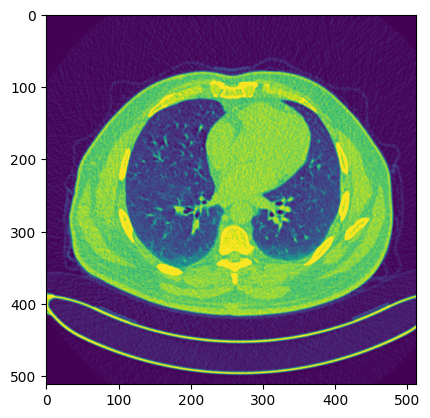

/root/.cache/kagglehub/datasets/adityamahimkar/iqothnccd-lung-cancer-dataset//versions/2/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset/Malignant cases
Malignant cases


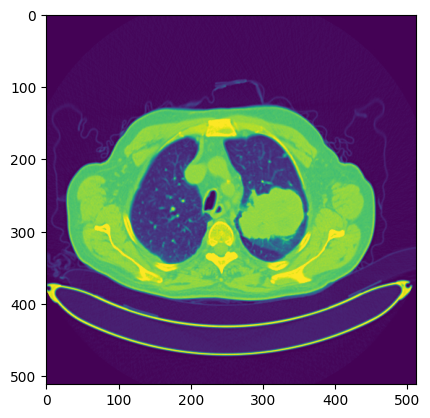

/root/.cache/kagglehub/datasets/adityamahimkar/iqothnccd-lung-cancer-dataset//versions/2/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset/Normal cases
Normal cases


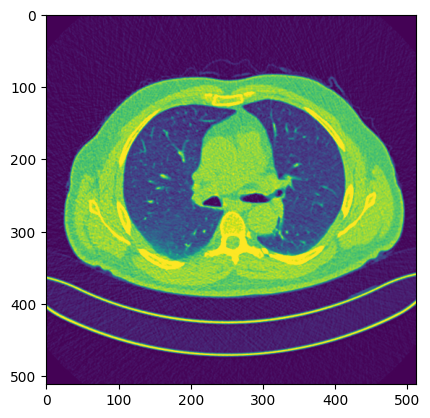

In [12]:
directory = "/root/.cache/kagglehub/datasets/adityamahimkar/iqothnccd-lung-cancer-dataset//versions/2/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset/"
for i in categories:
    category_path = os.path.join(directory, i) # Construct path for each category
    print(category_path)
    class_num = categories.index(i)
    for file in os.listdir(category_path): # List files in the category path
        filepath = os.path.join(category_path, file) # Construct filepath using category path
        print(i)
        img = cv2.imread(filepath, 0)
        if img is not None: # Check if image was loaded successfully
            plt.imshow(img)
            plt.show()
            break
        else:
            print(f"Failed to load image: {filepath}")

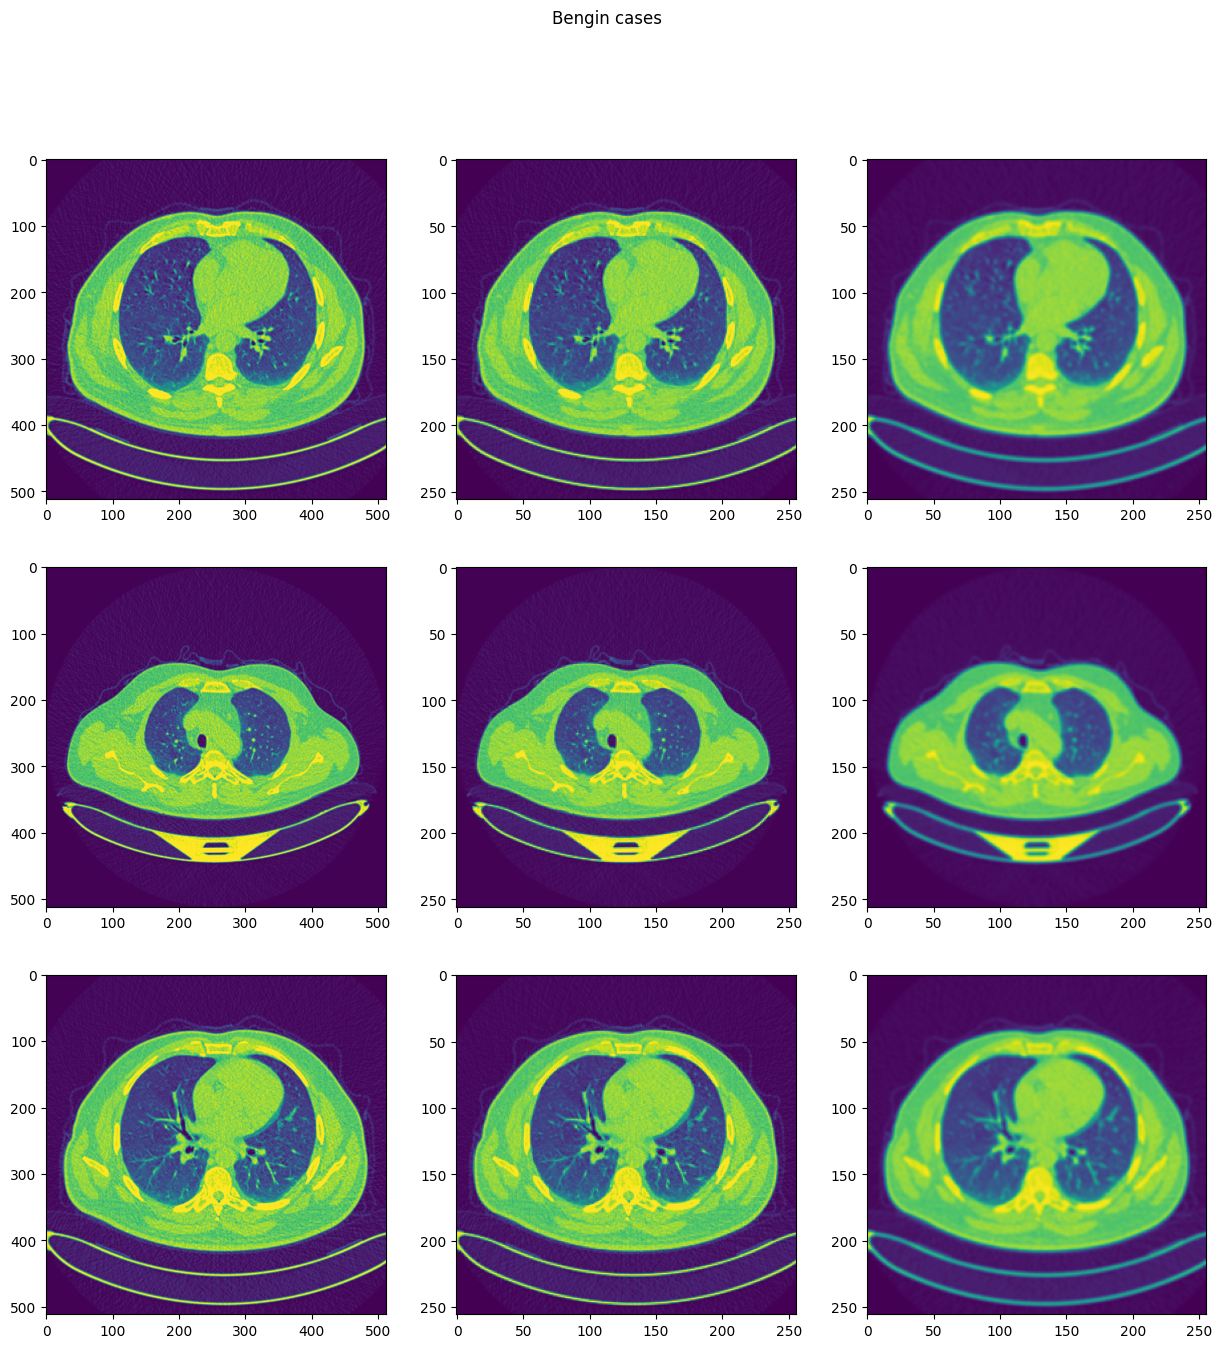

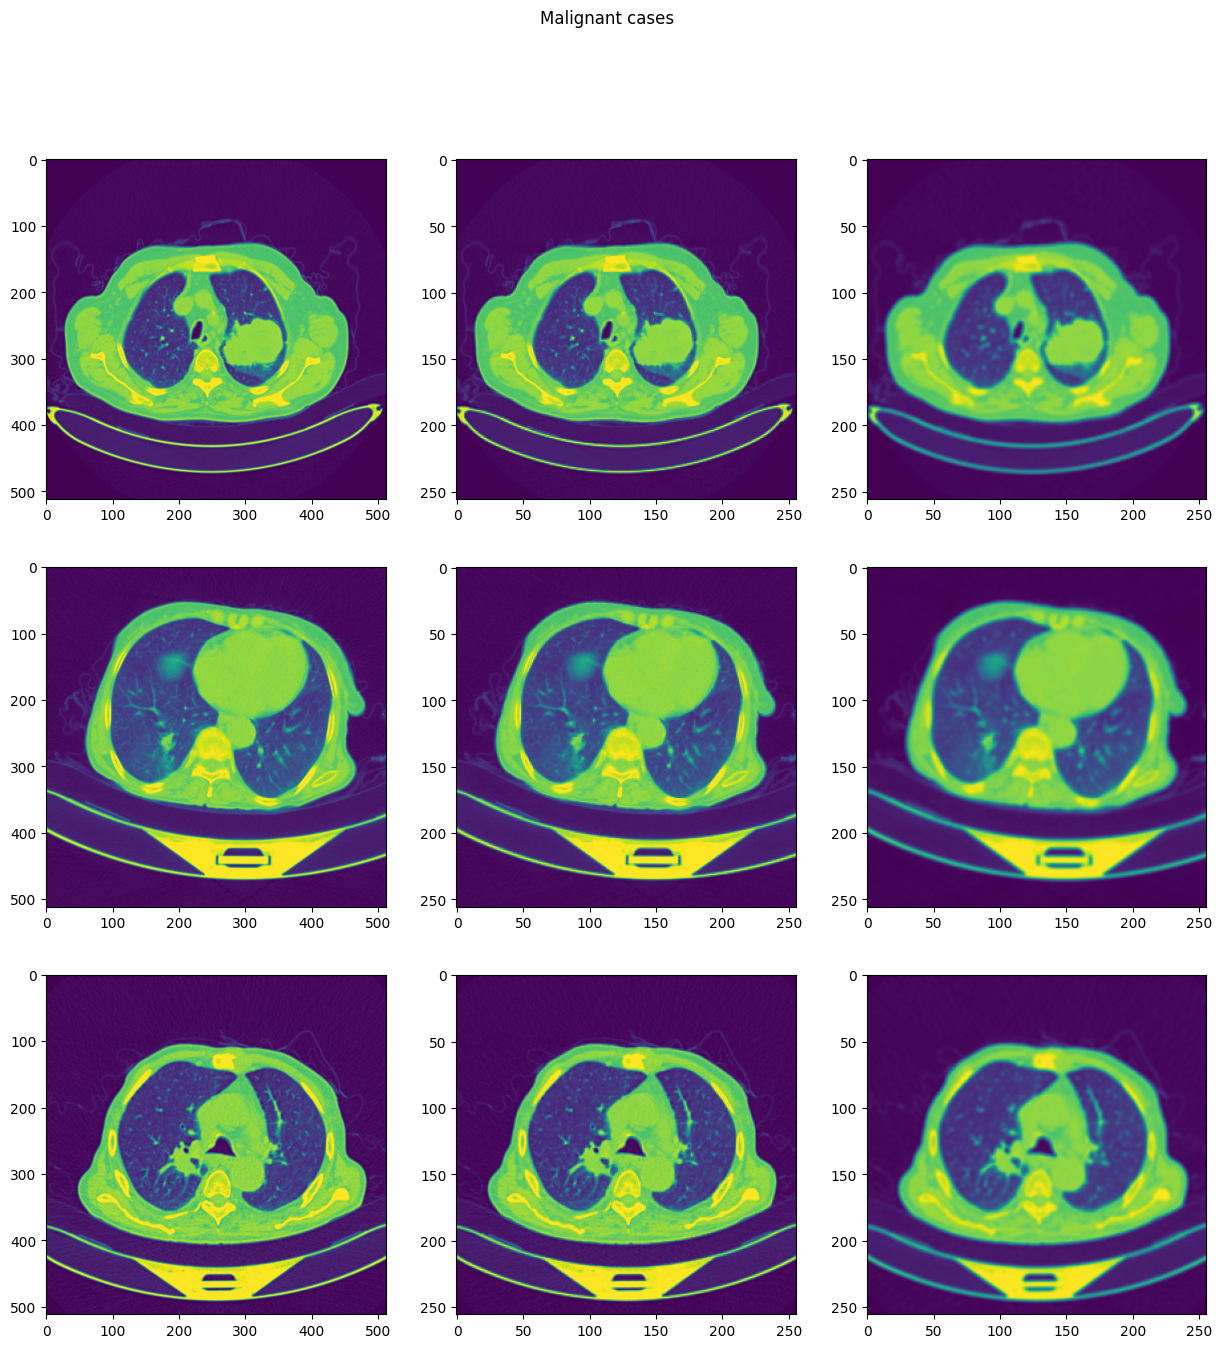

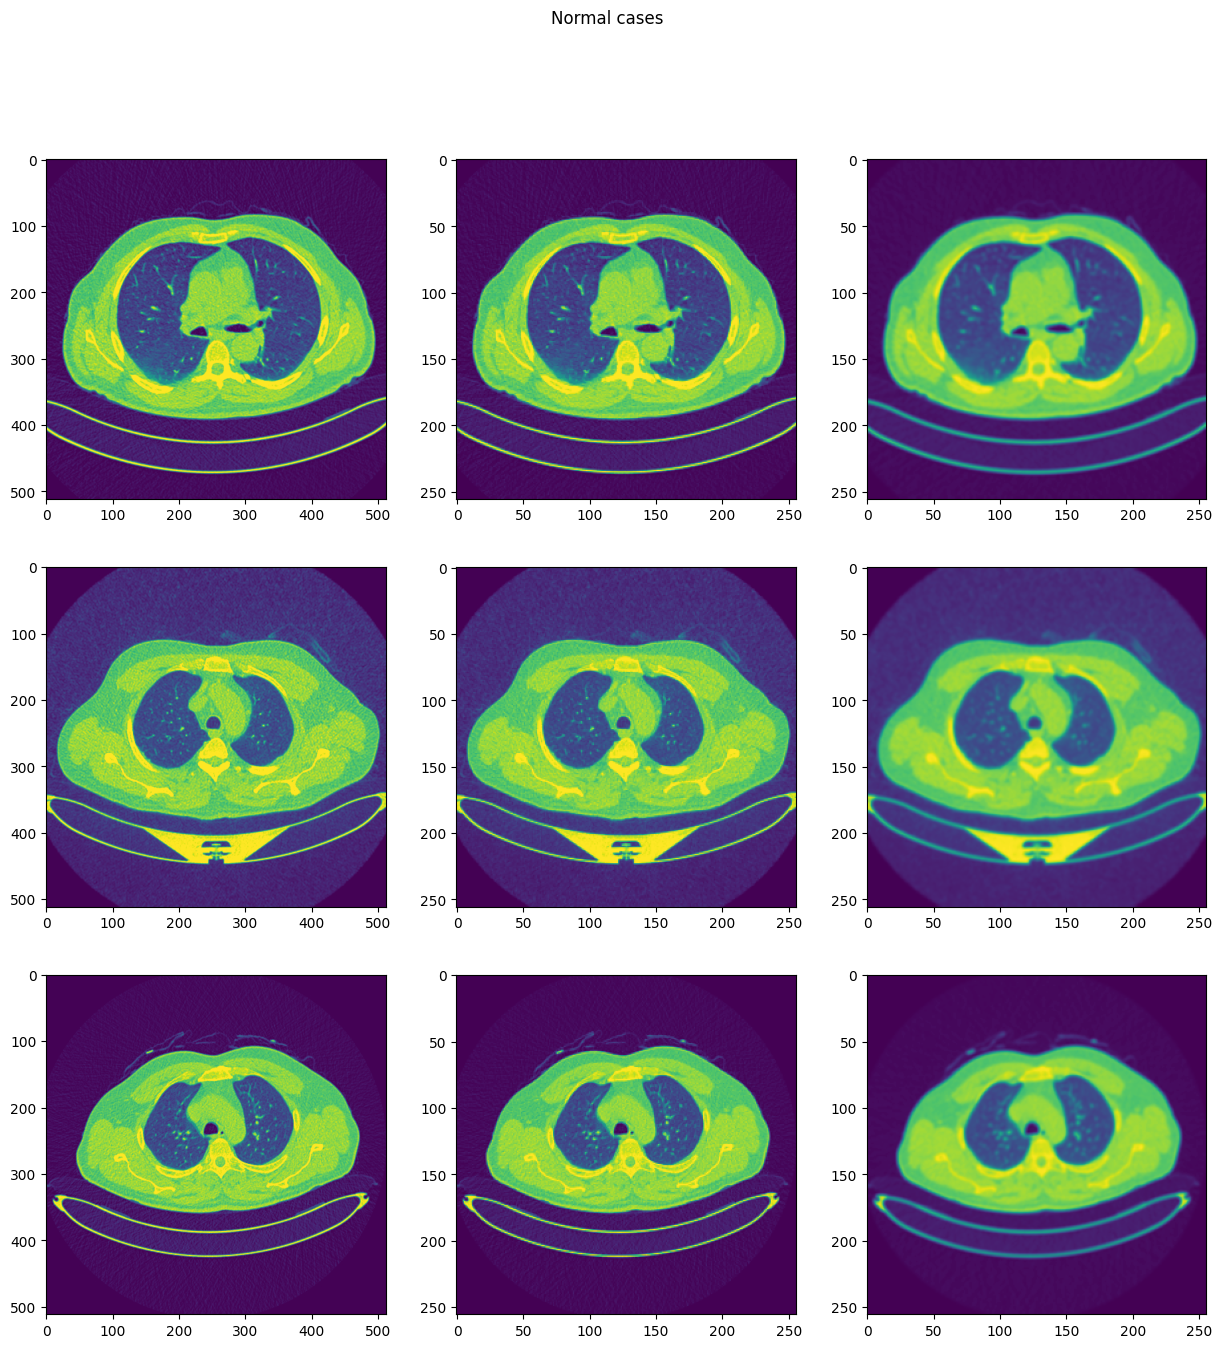

In [13]:
img_size = 256
for i in categories:
    cnt, samples = 0, 3
    fig, ax = plt.subplots(samples, 3, figsize=(15, 15))
    fig.suptitle(i)

    path = os.path.join(directory, i)
    class_num = categories.index(i)
    for curr_cnt, file in enumerate(os.listdir(path)):
        filepath = os.path.join(path, file)
        img = cv2.imread(filepath, 0)

        img0 = cv2.resize(img, (img_size, img_size))

        img1 = cv2.GaussianBlur(img0, (5, 5), 0)

        ax[cnt, 0].imshow(img)
        ax[cnt, 1].imshow(img0)
        ax[cnt, 2].imshow(img1)
        cnt += 1
        if cnt == samples:
            break

plt.show()

In [14]:
data = []
img_size = 256

for i in categories:
    path = os.path.join(directory, i)
    class_num = categories.index(i)
    for file in os.listdir(path):
        filepath = os.path.join(path, file)
        img = cv2.imread(filepath, 0)
        # preprocess here
        img = cv2.resize(img, (img_size, img_size))
        data.append([img, class_num])

random.shuffle(data)

X, y = [], []
for feature, label in data:
    X.append(feature)
    y.append(label)

print('X length:', len(X))
print('y counts:', Counter(y))

# normalize
X = np.array(X).reshape(-1, img_size, img_size, 1)
X = X / 255.0
y = np.array(y)

X length: 1097
y counts: Counter({1: 561, 2: 416, 0: 120})


In [15]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=10, stratify=y)

print(len(X_train), X_train.shape)
print(len(X_valid), X_valid.shape)

822 (822, 256, 256, 1)
275 (275, 256, 256, 1)


Applying SMOTE to oversample the data

In [16]:
print(Counter(y_train), Counter(y_valid))

Counter({1: 420, 2: 312, 0: 90}) Counter({1: 141, 2: 104, 0: 30})


In [17]:
print(len(X_train), X_train.shape)

X_train = X_train.reshape(X_train.shape[0], img_size*img_size*1)

print(len(X_train), X_train.shape)

822 (822, 256, 256, 1)
822 (822, 65536)


In [18]:
print('Before SMOTE:', Counter(y_train))
smote = SMOTE()
X_train_sampled, y_train_sampled = smote.fit_resample(X_train, y_train)
print('After SMOTE:', Counter(y_train_sampled))

Before SMOTE: Counter({1: 420, 2: 312, 0: 90})
After SMOTE: Counter({2: 420, 1: 420, 0: 420})


In [19]:
X_train = X_train.reshape(X_train.shape[0], img_size, img_size, 1)
X_train_sampled = X_train_sampled.reshape(X_train_sampled.shape[0], img_size, img_size, 1)

print(len(X_train), X_train.shape)
print(len(X_train_sampled), X_train_sampled.shape)

822 (822, 256, 256, 1)
1260 (1260, 256, 256, 1)


In [16]:
model1 = Sequential()

# Convolutional layers
model1.add(Conv2D(64, (3, 3), activation='relu', input_shape=X_train.shape[1:]))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Conv2D(128, (3, 3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Conv2D(256, (3, 3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the output of the convolutional layers
model1.add(Flatten())

# Fully connected layers
model1.add(Dense(512, activation='relu'))
model1.add(Dense(3, activation='softmax'))

model1.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 254, 254, 64)        │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 230400)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │     117,965,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │           1,539 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 118,336,515 (451.42 MB)

 Trainable params: 118,336,515 (451.42 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=0.0001)
model1.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model1.fit(X_train_sampled, y_train_sampled, batch_size=8, epochs=10, validation_data=(X_valid, y_valid))

Epoch 1/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 913s 6s/step - accuracy: 0.5471 - loss: 0.9669 - val_accuracy: 0.9164 - val_loss: 0.2408
Epoch 2/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 914s 6s/step - accuracy: 0.9629 - loss: 0.1318 - val_accuracy: 0.9673 - val_loss: 0.0878
Epoch 3/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 921s 6s/step - accuracy: 0.9943 - loss: 0.0256 - val_accuracy: 0.9673 - val_loss: 0.0766
Epoch 4/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 908s 6s/step - accuracy: 1.0000 - loss: 0.0053 - val_accuracy: 0.9818 - val_loss: 0.0600
Epoch 5/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 930s 6s/step - accuracy: 1.0000 - loss: 0.0029 - val_accuracy: 0.9782 - val_loss: 0.0800
Epoch 6/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 885s 6s/step - accuracy: 1.0000 - loss: 0.0025 - val_accuracy: 0.9782 - val_loss: 0.0831
Epoch 7/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 928s 6s/step - accuracy: 1.0000 - loss: 9.1587e-04 - val_accuracy: 0.9818 - val_loss: 0.0729
Epoch 8/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 926s 6s/step - accuracy: 1.0000 - loss: 4.0823e-04 - 

9/9 ━━━━━━━━━━━━━━━━━━━━ 61s 7s/step
              precision    recall  f1-score   support

           0       0.96      0.90      0.93        30
           1       1.00      0.99      1.00       141
           2       0.97      1.00      0.99       104

    accuracy                           0.99       275
   macro avg       0.98      0.96      0.97       275
weighted avg       0.99      0.99      0.99       275



Confusion Matrix:
 [[ 27   0   3]
 [  1 140   0]
 [  0   0 104]]


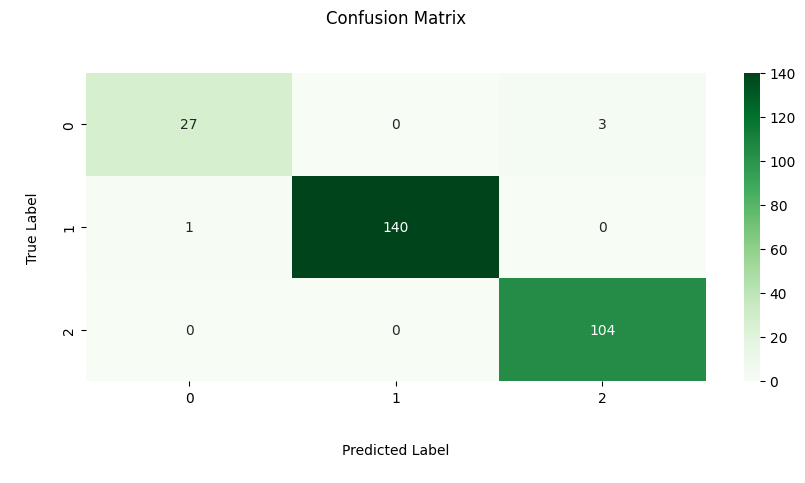

In [ ]:
y_pred = model1.predict(X_valid, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(y_valid, y_pred_bool))

cm = confusion_matrix(y_true=y_valid, y_pred=y_pred_bool)
print("\n\nConfusion Matrix:\n", cm)

plt.figure(figsize=(10,4))
sns.heatmap(cm, annot=True, fmt='g', cmap='Greens')
plt.xlabel('\n\nPredicted Label\n')
plt.ylabel('\nTrue Label\n')
plt.title('Confusion Matrix\n\n')
plt.show()

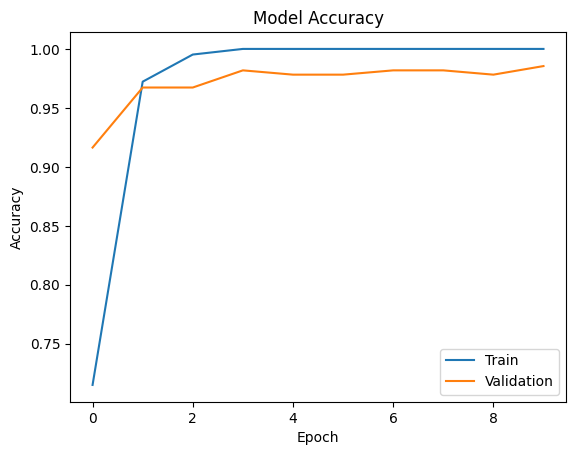

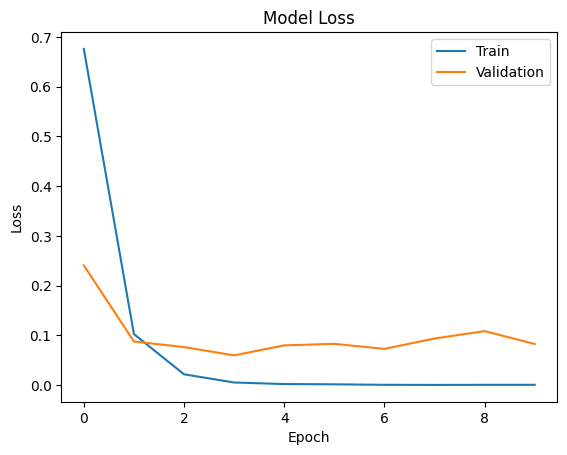

In [ ]:
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


#Retraining the model:
Adding dropout and L2 regularization

In [50]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.regularizers import l2

# Define the input dimension based on your data
input_dim = (256, 256, 1)  # For 256x256 grayscale images

model = Sequential([
    Flatten(input_shape=(256, 256, 1)),
    Dense(128, activation='relu', kernel_regularizer=l2(0.0001)),
    Dropout(0.1),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')
])


# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_5 (Flatten)                  │ (None, 65536)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 128)                 │       8,388,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,397,187 (32.03 MB)

 Trainable params: 8,397,187 (32.03 MB)

 Non-trainable params: 0 (0.00 B)

In [51]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=10,  # Reduced rotation
    width_shift_range=0.1,  # Reduced horizontal shift
    height_shift_range=0.1,  # Reduced vertical shift
    zoom_range=0.1,  # Reduced zoom
    horizontal_flip=True
)
datagen.fit(X_train)


In [52]:
from sklearn.model_selection import train_test_split

# Assuming your data is in variables `X` and `y`
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [53]:
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [54]:
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True, verbose=1
)


In [61]:
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=64),
    validation_data=(X_val, y_val),
    epochs=15,
    callbacks=[],
    steps_per_epoch=len(X_train) // 32,
    verbose=1
)


Epoch 1/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 203ms/step - accuracy: 0.6491 - loss: 0.8196 - val_accuracy: 0.7227 - val_loss: 0.7342
Epoch 2/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 181ms/step - accuracy: 0.6543 - loss: 0.8255 - val_accuracy: 0.7227 - val_loss: 0.7292
Epoch 3/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 164ms/step - accuracy: 0.6577 - loss: 0.8220 - val_accuracy: 0.7227 - val_loss: 0.7293
Epoch 4/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 230ms/step - accuracy: 0.6594 - loss: 0.8180 - val_accuracy: 0.7182 - val_loss: 0.7326
Epoch 5/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 166ms/step - accuracy: 0.6772 - loss: 0.8135 - val_accuracy: 0.7227 - val_loss: 0.7274
Epoch 6/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 12s 191ms/step - accuracy: 0.6504 - loss: 0.8285 - val_accuracy: 0.7227 - val_loss: 0.7238
Epoch 7/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 180ms/step - accuracy: 0.6421 - loss: 0.8447 - val_accuracy: 0.7182 - val_loss: 0.7341
Epoch 8/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 12s 166ms/step - accuracy: 0.6470 - loss: 0.8366 - val_accuracy:

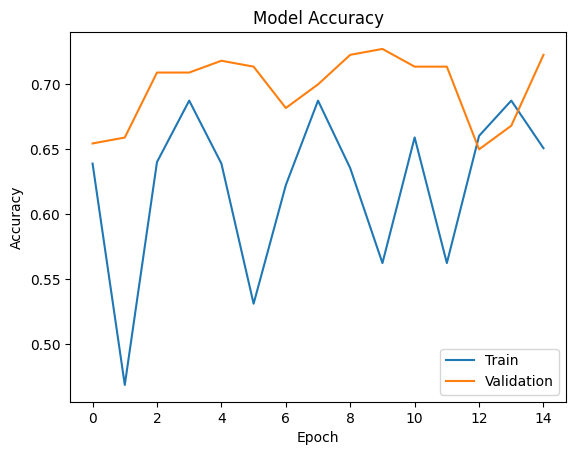

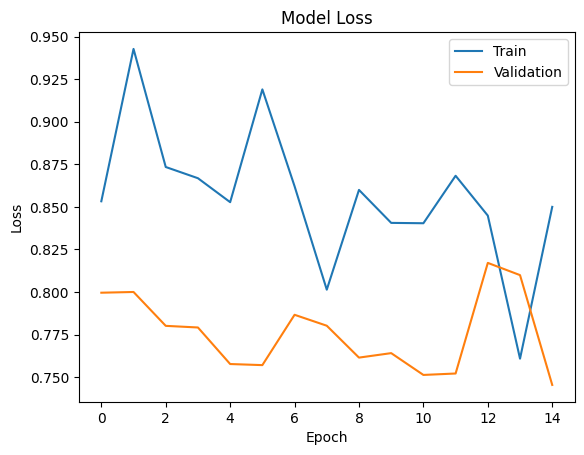

In [59]:
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


#Tunning Hyperparameters

In [20]:
# TensorFlow and Keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Keras Tuner for hyperparameter tuning
import keras_tuner as kt

In [24]:
def build_model(hp):
    model = Sequential()

    # Map integers to kernel sizes
    kernel_sizes = {0: (3, 3), 1: (5, 5)}

    # Convolutional layers
    model.add(Conv2D(
        filters=hp.Choice('conv_1_filters', values=[32, 64, 128]),
        kernel_size=kernel_sizes[hp.Choice('conv_1_kernel', values=[0, 1])],  # Map to tuple
        activation='relu',
        input_shape=(256, 256, 1)
    ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(
        filters=hp.Choice('conv_2_filters', values=[64, 128, 256]),
        kernel_size=(3, 3),
        activation='relu'
    ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(
        filters=hp.Choice('conv_3_filters', values=[128, 256, 512]),
        kernel_size=(3, 3),
        activation='relu'
    ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Fully connected layers
    model.add(Flatten())
    model.add(Dense(
        units=hp.Choice('dense_units', values=[128, 256, 512]),
        activation='relu'
    ))
    model.add(Dropout(rate=hp.Choice('dropout_rate', values=[0.2, 0.3, 0.4])))
    model.add(Dense(3, activation='softmax'))

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5])),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [25]:
tuner = kt.Hyperband(
    build_model,               # The model-building function
    objective='val_accuracy',  # The metric to optimize
    max_epochs=10,             # Max number of epochs for each trial
    factor=3,                  # Reduces the epochs after each bracket
    directory='hyperparameter_tuning',  # Directory to save tuning logs
    project_name='lung_cancer_model'    # Name of the project
)

Reloading Tuner from hyperparameter_tuning/lung_cancer_model/tuner0.json


In [ ]:
tuner.search(
    X_train, y_train,  # Training data
    epochs=10,                         # Number of epochs for each trial
    validation_data=(X_valid, y_valid) # Validation data
)

Trial 3 Complete [00h 14m 48s]
val_accuracy: 0.8218181729316711

Best val_accuracy So Far: 0.8618181943893433
Total elapsed time: 01h 34m 30s

Search: Running Trial #4

Value             |Best Value So Far |Hyperparameter
128               |128               |conv_1_filters
1                 |0                 |conv_1_kernel
128               |256               |conv_2_filters
512               |512               |conv_3_filters
256               |256               |dense_units
0.3               |0.2               |dropout_rate
1e-05             |0.0001            |learning_rate
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
2                 |2                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/2


In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]  # Get the best hyperparameter set
print("Best Hyperparameters:", best_hps.values)

In [ ]:
# Build the best model
model = tuner.hypermodel.build(best_hps)

# Train the model with the best hyperparameters
history = model.fit(
    X_train, y_train,
    epochs=20,  # You can extend training here
    batch_size=16,  # You can set this to the best batch size if tuned
    validation_data=(X_valid, y_valid)
)

In [ ]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


In [ ]:
model.save('lung_cancer_tuned_model.h5')

In [ ]:
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()